<a href="https://colab.research.google.com/github/KizuAnee/XGBoos-Collab---UAS-IntSys/blob/main/UAS_IntSys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Kode PROGRAM ASLI

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- Langkah 1 & 2: Memuat, Membersihkan, dan Melakukan Encoding Data ---
# Metodologi ini sejalan dengan bagian 3.2, 3.3, dan 3.4 dari jurnal.

# Memuat dataset dari Kaggle seperti yang disebutkan di jurnal
try:
    df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
except FileNotFoundError:
    print("File dataset tidak ditemukan. Pastikan file 'WA_Fn-UseC_-Telco-Customer-Churn.csv' ada di folder yang sama.")
    exit()

# Menghapus kolom customerID karena tidak memiliki kontribusi
df.drop(columns=['customerID'], inplace=True)

# Mengubah 'TotalCharges' menjadi numerik, menangani nilai kosong
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

# Mengubah kolom target 'Churn' dari Yes/No menjadi 1/0
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Memisahkan fitur (X) dan target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# One-hot encoding untuk semua fitur kategorikal
X = pd.get_dummies(X, drop_first=True)


# --- Langkah 3: Pembagian Data dengan Stratifikasi ---
# Jurnal menekankan pentingnya menjaga rasio churn
# 'stratify=y' memastikan rasio kelas target sama di data latih dan uji.
# 'random_state=42' digunakan seperti dalam jurnal
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, # Menggunakan 25% untuk test agar mirip dengan data di jurnal
    random_state=42,
    stratify=y
)

print(f"Bentuk data latih: {X_train.shape}")
print(f"Bentuk data uji: {X_test.shape}")
print("-" * 30)


# --- Langkah 4 & 5: Optimisasi Hyperparameter dengan Grid Search ---
# Sejalan dengan bagian 3.7 di jurnal

# Menghitung scale_pos_weight untuk menangani kelas tidak seimbang.
# Ini adalah implementasi dari konsep yang digunakan jurnal untuk meningkatkan akurasi kelas minoritas
scale_pos_weight_value = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Nilai scale_pos_weight yang dihitung: {scale_pos_weight_value:.2f}")
print("-" * 30)

# Mendefinisikan grid parameter untuk dicari oleh GridSearchCV
# Nilai-nilai ini terinspirasi dari Tabel 7 & 8 di jurnal
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1],
    'gamma': [0.1, 0.25, 0.5],
    'reg_lambda': [1, 5, 10],
    'scale_pos_weight': [3, scale_pos_weight_value] # Jurnal menggunakan 3, kita juga coba nilai hitungan
}

# Inisialisasi model XGBoost dasar
xgb_model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42)

# Inisialisasi GridSearchCV
# cv=5 berarti 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='recall', # Fokus pada 'recall' untuk memaksimalkan deteksi churn (True Positives)
    cv=5,
    verbose=1,
    n_jobs=-1
)

print("Memulai proses optimisasi dengan GridSearchCV...")
# Melatih model dengan grid search untuk menemukan parameter terbaik
grid_search.fit(X_train, y_train)

# Menampilkan parameter terbaik yang ditemukan
print("\n--- Hasil Optimisasi Selesai ---")
print("Parameter terbaik yang ditemukan:")
print(grid_search.best_params_)
print("-" * 30)


# --- Langkah 6: Evaluasi Model Terbaik ---
# Menggunakan model terbaik untuk prediksi dan evaluasi, sesuai bagian akhir jurnal

# Dapatkan model terbaik dari hasil pencarian
best_model = grid_search.best_estimator_

# Lakukan prediksi pada data uji
y_pred = best_model.predict(X_test)

# Tampilkan hasil evaluasi akhir
print("\n--- Evaluasi Model Terbaik pada Data Test ---")
print(f"Akurasi Keseluruhan: {accuracy_score(y_test, y_pred):.4f}\n")

print("Confusion Matrix:")
# Mencetak confusion matrix, mirip dengan Tabel 9 di jurnal
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
print("\n   Label          | Predicted 'No' | Predicted 'Yes'")
print("-------------------------------------------------")
print(f"   True 'No'      | {conf_matrix[0][0]:<14} | {conf_matrix[0][1]:<15}")
print(f"   True 'Yes'     | {conf_matrix[1][0]:<14} | {conf_matrix[1][1]:<15}")


print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Did not Leave', 'Left']))

# Menghitung akurasi untuk kelas 'Left' (Churn) seperti pada Tabel 10 jurnal
accuracy_left = conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])
print(f"\nAkurasi pada prediksi pelanggan yang 'Left' (Churn): {accuracy_left:.2%}")

Bentuk data latih: (5274, 30)
Bentuk data uji: (1758, 30)
------------------------------
Nilai scale_pos_weight yang dihitung: 2.76
------------------------------
Memulai proses optimisasi dengan GridSearchCV...
Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:07:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Hasil Optimisasi Selesai ---
Parameter terbaik yang ditemukan:
{'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 3, 'reg_lambda': 10, 'scale_pos_weight': 3}
------------------------------

--- Evaluasi Model Terbaik pada Data Test ---
Akurasi Keseluruhan: 0.7247

Confusion Matrix:
[[883 408]
 [ 76 391]]

   Label          | Predicted 'No' | Predicted 'Yes'
-------------------------------------------------
   True 'No'      | 883            | 408            
   True 'Yes'     | 76             | 391            

Classification Report:
               precision    recall  f1-score   support

Did not Leave       0.92      0.68      0.78      1291
         Left       0.49      0.84      0.62       467

     accuracy                           0.72      1758
    macro avg       0.71      0.76      0.70      1758
 weighted avg       0.81      0.72      0.74      1758


Akurasi pada prediksi pelanggan yang 'Left' (Churn): 83.73%


In [ ]:
# Kode PROGRAM hasil tuning menggunakan HalvingRandomSearchCV

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv  # wajib di-import dulu
from sklearn.model_selection import HalvingRandomSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.stats import uniform, randint

# --- Langkah 1 & 2: Memuat dan Membersihkan Data ---
try:
    df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
except FileNotFoundError:
    print("File dataset tidak ditemukan.")
    exit()

df.drop(columns=['customerID'], inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

X = df.drop('Churn', axis=1)
y = df['Churn']
X = pd.get_dummies(X, drop_first=True)

# --- Langkah 3: Pembagian Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

print(f"Bentuk data latih: {X_train.shape}")
print(f"Bentuk data uji: {X_test.shape}")
print("-" * 30)

# --- Langkah 4 & 5: Optimisasi Hyperparameter dengan HalvingRandomSearchCV ---
scale_pos_weight_value = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Nilai scale_pos_weight yang dihitung: {scale_pos_weight_value:.2f}")
print("-" * 30)

param_dist = {
    'max_depth': randint(3, 7),
    'learning_rate': uniform(0.01, 0.2),
    'gamma': uniform(0, 0.5),
    'reg_lambda': randint(1, 11),
    'scale_pos_weight': [3, scale_pos_weight_value]
}

xgb_model = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

halving_search = HalvingRandomSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    factor=3,  # eliminasi kombinasi buruk 1/3 dari total tiap iterasi
    scoring='recall',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("Memulai proses optimisasi dengan HalvingRandomSearchCV...")
halving_search.fit(X_train, y_train)

print("\n--- Hasil Optimisasi Selesai ---")
print("Parameter terbaik yang ditemukan:")
print(halving_search.best_params_)
print("-" * 30)

# --- Langkah 6: Evaluasi Model Terbaik ---
best_model = halving_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\n--- Evaluasi Model Terbaik pada Data Test ---")
print(f"Akurasi Keseluruhan: {accuracy_score(y_test, y_pred):.4f}\n")

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print("\n   Label          | Predicted 'No' | Predicted 'Yes'")
print("-------------------------------------------------")
print(f"   True 'No'      | {conf_matrix[0][0]:<14} | {conf_matrix[0][1]:<15}")
print(f"   True 'Yes'     | {conf_matrix[1][0]:<14} | {conf_matrix[1][1]:<15}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Did not Leave', 'Left']))

accuracy_left = conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])
print(f"\nAkurasi pada prediksi pelanggan yang 'Left' (Churn): {accuracy_left:.2%}")


Bentuk data latih: (5274, 30)
Bentuk data uji: (1758, 30)
------------------------------
Nilai scale_pos_weight yang dihitung: 2.76
------------------------------
Memulai proses optimisasi dengan HalvingRandomSearchCV...
n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 20
max_resources_: 5274
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 263
n_resources: 20
Fitting 5 folds for each of 263 candidates, totalling 1315 fits
----------
iter: 1
n_candidates: 88
n_resources: 60
Fitting 5 folds for each of 88 candidates, totalling 440 fits
----------
iter: 2
n_candidates: 30
n_resources: 180
Fitting 5 folds for each of 30 candidates, totalling 150 fits
----------
iter: 3
n_candidates: 10
n_resources: 540
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 4
n_candidates: 4
n_resources: 1620
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 5
n_candidates: 2
n_resources: 4860
Fitting

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:15:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔍 Tuning dengan GridSearchCV...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:18:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Akurasi GridSearchCV: 0.7423
⚡ Tuning dengan HalvingRandomSearchCV...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:20:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Akurasi HalvingRandomSearchCV: 0.7543


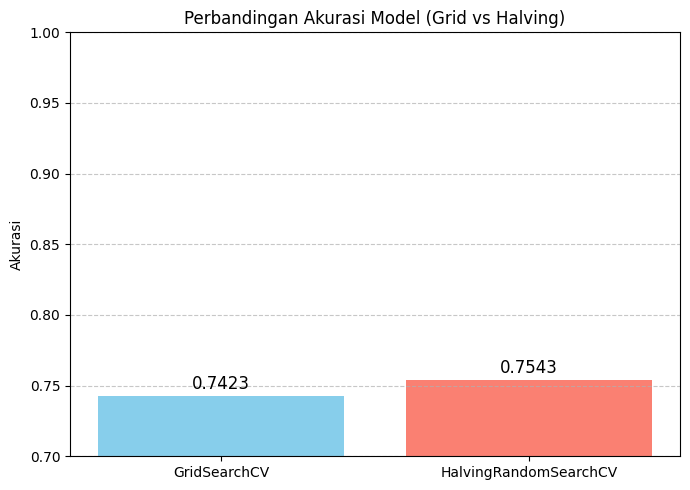

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

# --- Step 1: Load & Clean Data ---
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.drop(columns=['customerID'], inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
X = pd.get_dummies(df.drop('Churn', axis=1), drop_first=True)
y = df['Churn']

# --- Step 2: Split Dataset ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

scale_pos_weight_value = y_train.value_counts()[0] / y_train.value_counts()[1]

# --- Step 3A: GridSearchCV ---
grid_params = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1],
    'gamma': [0.1, 0.25, 0.5],
    'reg_lambda': [1, 5, 10],
    'scale_pos_weight': [3, scale_pos_weight_value]
}

xgb_model_grid = XGBClassifier(
    objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb_model_grid,
    param_grid=grid_params,
    scoring='accuracy',
    cv=5,
    verbose=0,
    n_jobs=-1
)

print("🔍 Tuning dengan GridSearchCV...")
grid_search.fit(X_train, y_train)
grid_model = grid_search.best_estimator_
grid_pred = grid_model.predict(X_test)
grid_acc = accuracy_score(y_test, grid_pred)
print(f"✅ Akurasi GridSearchCV: {grid_acc:.4f}")

# --- Step 3B: HalvingRandomSearchCV ---
random_dist = {
    'max_depth': randint(3, 7),
    'learning_rate': uniform(0.01, 0.2),
    'gamma': uniform(0, 0.5),
    'reg_lambda': randint(1, 11),
    'scale_pos_weight': [3, scale_pos_weight_value]
}

xgb_model_halving = XGBClassifier(
    objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42
)

halving_search = HalvingRandomSearchCV(
    estimator=xgb_model_halving,
    param_distributions=random_dist,
    factor=3,
    scoring='accuracy',
    cv=5,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

print("⚡ Tuning dengan HalvingRandomSearchCV...")
halving_search.fit(X_train, y_train)
halving_model = halving_search.best_estimator_
halving_pred = halving_model.predict(X_test)
halving_acc = accuracy_score(y_test, halving_pred)
print(f"✅ Akurasi HalvingRandomSearchCV: {halving_acc:.4f}")

# --- Step 4: Plot Comparison ---
plt.figure(figsize=(7, 5))
metode = ['GridSearchCV', 'HalvingRandomSearchCV']
akurasi = [grid_acc, halving_acc]
plt.bar(metode, akurasi, color=['skyblue', 'salmon'])
plt.title('Perbandingan Akurasi Model (Grid vs Halving)')
plt.ylabel('Akurasi')
plt.ylim(0.7, 1)
for i, v in enumerate(akurasi):
    plt.text(i, v + 0.005, f"{v:.4f}", ha='center', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


🔍 Tuning dengan GridSearchCV...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:28:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Recall (Churn - GridSearchCV): 0.8373
⚡ Tuning dengan HalvingRandomSearchCV...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:30:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Recall (Churn - HalvingRandomSearchCV): 0.8501


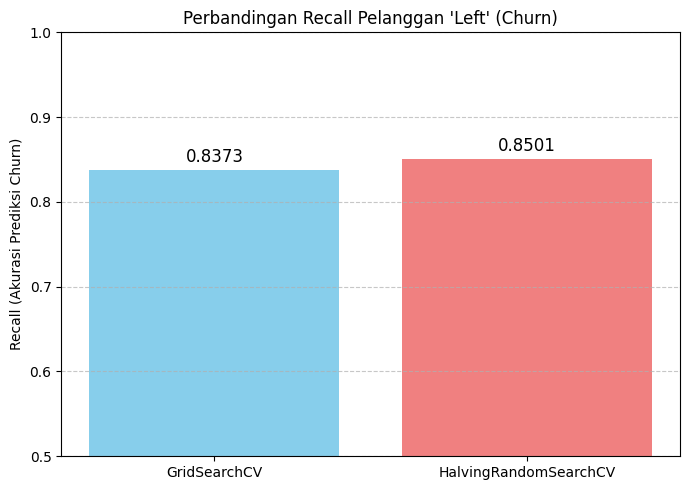

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

# --- Langkah 1: Memuat & Membersihkan Data ---
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.drop(columns=['customerID'], inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

X = pd.get_dummies(df.drop('Churn', axis=1), drop_first=True)
y = df['Churn']

# --- Langkah 2: Split Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

scale_pos_weight_value = y_train.value_counts()[0] / y_train.value_counts()[1]

# --- Langkah 3A: Tuning dengan GridSearchCV ---
grid_params = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1],
    'gamma': [0.1, 0.25, 0.5],
    'reg_lambda': [1, 5, 10],
    'scale_pos_weight': [3, scale_pos_weight_value]
}

grid_model = XGBClassifier(objective='binary:logistic', use_label_encoder=False,
                           eval_metric='logloss', random_state=42)

grid_search = GridSearchCV(
    estimator=grid_model,
    param_grid=grid_params,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=0
)

print("🔍 Tuning dengan GridSearchCV...")
grid_search.fit(X_train, y_train)
grid_best = grid_search.best_estimator_
grid_pred = grid_best.predict(X_test)

# Hitung recall spesifik untuk 'Left'
grid_cm = confusion_matrix(y_test, grid_pred)
grid_recall_left = grid_cm[1][1] / (grid_cm[1][0] + grid_cm[1][1])

print(f"✅ Recall (Churn - GridSearchCV): {grid_recall_left:.4f}")

# --- Langkah 3B: Tuning dengan HalvingRandomSearchCV ---
random_dist = {
    'max_depth': randint(3, 7),
    'learning_rate': uniform(0.01, 0.2),
    'gamma': uniform(0, 0.5),
    'reg_lambda': randint(1, 11),
    'scale_pos_weight': [3, scale_pos_weight_value]
}

halving_model = XGBClassifier(objective='binary:logistic', use_label_encoder=False,
                              eval_metric='logloss', random_state=42)

halving_search = HalvingRandomSearchCV(
    estimator=halving_model,
    param_distributions=random_dist,
    scoring='recall',
    factor=3,
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

print("⚡ Tuning dengan HalvingRandomSearchCV...")
halving_search.fit(X_train, y_train)
halving_best = halving_search.best_estimator_
halving_pred = halving_best.predict(X_test)

halving_cm = confusion_matrix(y_test, halving_pred)
halving_recall_left = halving_cm[1][1] / (halving_cm[1][0] + halving_cm[1][1])

print(f"✅ Recall (Churn - HalvingRandomSearchCV): {halving_recall_left:.4f}")

# --- Langkah 4: Plot Perbandingan Recall untuk Pelanggan Churn ---
plt.figure(figsize=(7, 5))
metode = ['GridSearchCV', 'HalvingRandomSearchCV']
recalls = [grid_recall_left, halving_recall_left]

plt.bar(metode, recalls, color=['skyblue', 'lightcoral'])
plt.title("Perbandingan Recall Pelanggan 'Left' (Churn)")
plt.ylabel("Recall (Akurasi Prediksi Churn)")
plt.ylim(0.5, 1.0)

for i, val in enumerate(recalls):
    plt.text(i, val + 0.01, f"{val:.4f}", ha='center', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
